# This notebook is Exploratory Data Analysis and Building ML MODELS Date - 11/04/20

The code cell contains all the necessary imports for this file

In [24]:
import numpy as np    #-------------- 
import pandas as pd   #             |
import seaborn as sns #             | -- Basic Libraries used for loading,modifying and plotting data
import matplotlib.pyplot as plt #   |
#------------------------------------

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

file_name = "reddit_flair_data.csv"
%matplotlib inline

We load in the reddit_flair_data.csv file and have a look at the first 5 samples of it

In [25]:
df = pd.read_csv(file_name)
df.head()

id     flair                                              title  \
0  fwjdqr  AskIndia  4 days ago we had pending orders of 100 millio...   
1  fizkkk  AskIndia  randians who were big time users of dating app...   
2  f25vx0  AskIndia  what does r india thinks about the flat earthers    
3  dtvliq  AskIndia  people who left their 9 to 5 jobs to pursue a ...   
4  b7pvwt  AskIndia   somebody want to kill my full family what to do    

                                                body  num_cmnts  \
0   we are getting frantic calls from our pharma ...          6   
1  i d my own stint with these apps a couple of m...         19   
2  i encountered a foreigner in ig who says round...         31   
3  couldn t add askindia flair from the mobile br...         34   
4  it s now 24hrs but local police station is not...         24   

               created  score  \
0  2020-04-08 01:37:04     94   
1  2020-03-16 00:18:06     20   
2  2020-02-11 22:40:55      4   
3  2019-11-10 02:27:35     44   
4  2019-04-01 06:30:35     94   

                                            comments  
0   modi has stockholm syndrome to be fair the ev...  
1   someone matched with me just to tell me that ...  
2   i haven t found a indian yet who believes ear...  
3   an engineer doing advertisement shoots since ...  
4   calm down go to the sp office of your town fi...

Here I combined all the text from the title,body and comments as a single entity to work on their combinations

In [26]:
def combined_features(df):
    '''
    takes in the dataframe object and returns the new dataframe which has the column of combined features
    '''
    combined = ' '
    combined_list=[]
    titles = list(df['title'])
    bodys = list(df['body'])
    comments = list(df['comments'])
    for i in range(len(titles)):
        combined = re.sub('[0-9]','',combined + str(titles[i]) + str(bodys[i]) + str(comments[i]))
        combined_list.append(combined)
        combined = ' ' 
    df['combined_features'] = combined_list
    return df
df = combined_features(df)

In [27]:
df

id     flair                                              title  \
0     fwjdqr  AskIndia  4 days ago we had pending orders of 100 millio...   
1     fizkkk  AskIndia  randians who were big time users of dating app...   
2     f25vx0  AskIndia  what does r india thinks about the flat earthers    
3     dtvliq  AskIndia  people who left their 9 to 5 jobs to pursue a ...   
4     b7pvwt  AskIndia   somebody want to kill my full family what to do    
...      ...       ...                                                ...   
2195  fzvi3k      Food            rise of india praising youtube channels   
2196  fs6ggv      Food                           plan source in comments    
2197  faqinz      Food  cake sponges being delivered to a bakery in noida   
2198  drvs1m      Food  chennai food delivery boys thrash customer aft...   
2199  exmve4      Food  gamble with the tax axe budget story lower req...   

                                                   body  num_cmnts  \
0      we are getting frantic calls from our pharma ...          6   
1     i d my own stint with these apps a couple of m...         19   
2     i encountered a foreigner in ig who says round...         31   
3     couldn t add askindia flair from the mobile br...         34   
4     it s now 24hrs but local police station is not...         24   
...                                                 ...        ...   
2195  from few months i am noticing something on you...         21   
2196                                                NaN         13   
2197                                                NaN         78   
2198                                                NaN         21   
2199                                                NaN          1   

                  created  score  \
0     2020-04-08 01:37:04     94   
1     2020-03-16 00:18:06     20   
2     2020-02-11 22:40:55      4   
3     2019-11-10 02:27:35     44   
4     2019-04-01 06:30:35     94   
...                   ...    ...   
2195  2020-04-13 01:29:59     25   
2196  2020-03-31 18:04:34    283   
2197  2020-02-28 20:02:34    545   
2198  2019-11-05 20:46:01    120   
2199  2020-02-03 00:27:43     15   

                                               comments  \
0      modi has stockholm syndrome to be fair the ev...   
1      someone matched with me just to tell me that ...   
2      i haven t found a indian yet who believes ear...   
3      an engineer doing advertisement shoots since ...   
4      calm down go to the sp office of your town fi...   
...                                                 ...   
2195   they are just using indian population for mon...   
2196   haven t even seen amit shah since long his pr...   
2197   this is the bakery https www zomato com ncr f...   
2198   bas yahi baki thha on the day of the incident...   
2199   some other post budget op eds ft com indian m...   

                                      combined_features  
0       days ago we had pending orders of  million h...  
1      randians who were big time users of dating ap...  
2      what does r india thinks about the flat earth...  
3      people who left their  to  jobs to pursue a c...  
4      somebody want to kill my full family what to ...  
...                                                 ...  
2195   rise of india praising youtube channelsfrom f...  
2196   plan source in comments nan haven t even seen...  
2197   cake sponges being delivered to a bakery in n...  
2198   chennai food delivery boys thrash customer af...  
2199   gamble with the tax axe budget story lower re...  

[2200 rows x 9 columns]

Applying Tokenization and removing stopwords

In [28]:
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['combined_features'].apply(word_tokenize)
df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

Also added the sentiment for the reddit post and the word count (for combination of each title,body,comments)

In [29]:
df['polarity'] = df['combined_features'].map(lambda text: TextBlob(text).sentiment.polarity)
df['word_count'] = df['combined_features'].apply(lambda x: len(str(x).split()))

In [30]:
df

id     flair                                              title  \
0     fwjdqr  AskIndia  4 days ago we had pending orders of 100 millio...   
1     fizkkk  AskIndia  randians who were big time users of dating app...   
2     f25vx0  AskIndia  what does r india thinks about the flat earthers    
3     dtvliq  AskIndia  people who left their 9 to 5 jobs to pursue a ...   
4     b7pvwt  AskIndia   somebody want to kill my full family what to do    
...      ...       ...                                                ...   
2195  fzvi3k      Food            rise of india praising youtube channels   
2196  fs6ggv      Food                           plan source in comments    
2197  faqinz      Food  cake sponges being delivered to a bakery in noida   
2198  drvs1m      Food  chennai food delivery boys thrash customer aft...   
2199  exmve4      Food  gamble with the tax axe budget story lower req...   

                                                   body  num_cmnts  \
0      we are getting frantic calls from our pharma ...          6   
1     i d my own stint with these apps a couple of m...         19   
2     i encountered a foreigner in ig who says round...         31   
3     couldn t add askindia flair from the mobile br...         34   
4     it s now 24hrs but local police station is not...         24   
...                                                 ...        ...   
2195  from few months i am noticing something on you...         21   
2196                                                NaN         13   
2197                                                NaN         78   
2198                                                NaN         21   
2199                                                NaN          1   

                  created  score  \
0     2020-04-08 01:37:04     94   
1     2020-03-16 00:18:06     20   
2     2020-02-11 22:40:55      4   
3     2019-11-10 02:27:35     44   
4     2019-04-01 06:30:35     94   
...                   ...    ...   
2195  2020-04-13 01:29:59     25   
2196  2020-03-31 18:04:34    283   
2197  2020-02-28 20:02:34    545   
2198  2019-11-05 20:46:01    120   
2199  2020-02-03 00:27:43     15   

                                               comments  \
0      modi has stockholm syndrome to be fair the ev...   
1      someone matched with me just to tell me that ...   
2      i haven t found a indian yet who believes ear...   
3      an engineer doing advertisement shoots since ...   
4      calm down go to the sp office of your town fi...   
...                                                 ...   
2195   they are just using indian population for mon...   
2196   haven t even seen amit shah since long his pr...   
2197   this is the bakery https www zomato com ncr f...   
2198   bas yahi baki thha on the day of the incident...   
2199   some other post budget op eds ft com indian m...   

                                      combined_features  \
0       days ago we had pending orders of  million h...   
1      randians who were big time users of dating ap...   
2      what does r india thinks about the flat earth...   
3      people who left their  to  jobs to pursue a c...   
4      somebody want to kill my full family what to ...   
...                                                 ...   
2195   rise of india praising youtube channelsfrom f...   
2196   plan source in comments nan haven t even seen...   
2197   cake sponges being delivered to a bakery in n...   
2198   chennai food delivery boys thrash customer af...   
2199   gamble with the tax axe budget story lower re...   

                                              tokenized  \
0     [days, ago, we, had, pending, orders, of, mill...   
1     [randians, who, were, big, time, users, of, da...   
2     [what, does, r, india, thinks, about, the, fla...   
3     [people, who, left, their, to, jobs, to, pursu...   
4     [somebody, want, to, kill, my, full, family, w...   
...                                    

Let's see the distribution of each label(flair) in the dataset

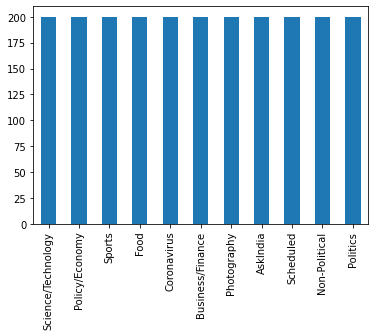

In [33]:
df['flair'].value_counts().plot(kind='bar')

Looking at the highest and lowest polarity scores

In [34]:
print(df.polarity.max())
print(df.polarity.min())

1.0
-1.0


Plotting the Histogram of the polarity score

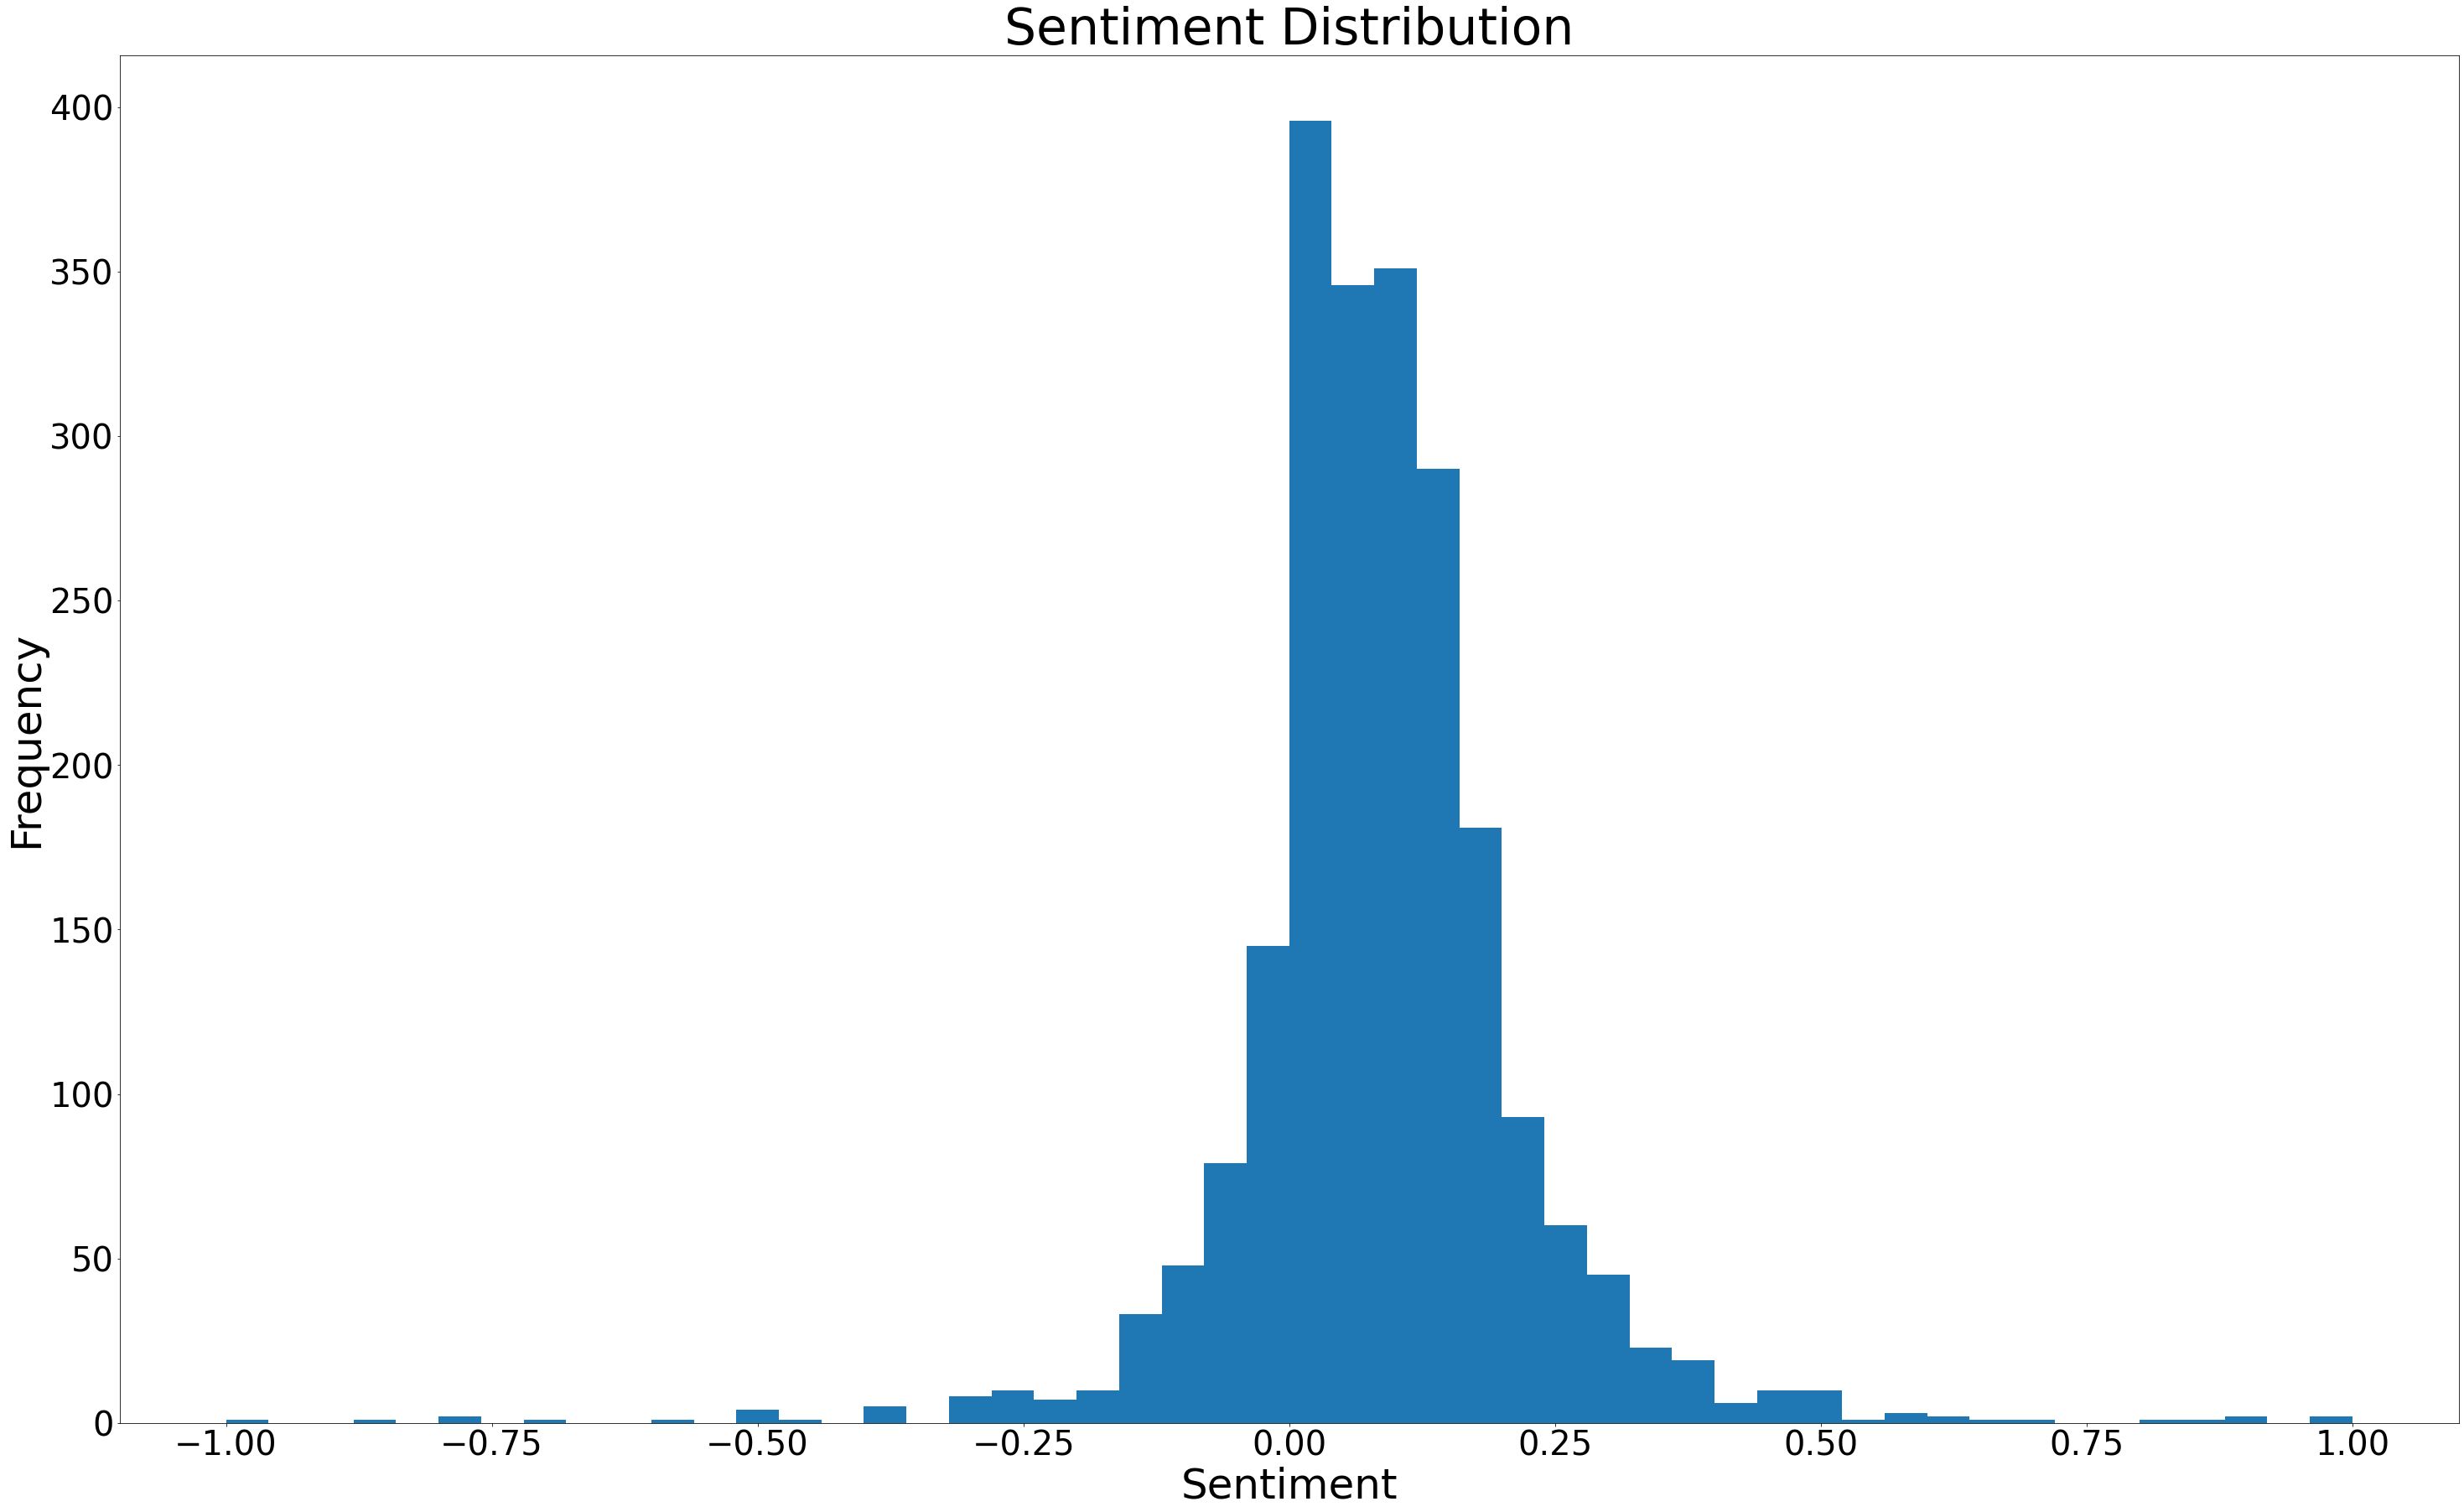

'Vast majority of the sentiment polarity scores are >0, means most of them are positive'

In [40]:
plt.figure(figsize=(50,30))
plt.xlabel('Sentiment',fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency',fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['polarity'],bins=50)
plt.title('Sentiment Distribution',fontsize=60)
plt.show()

'''Vast majority of the sentiment polarity scores are >0, means most of them are positive'''

Plotting the Histogram of the Scores

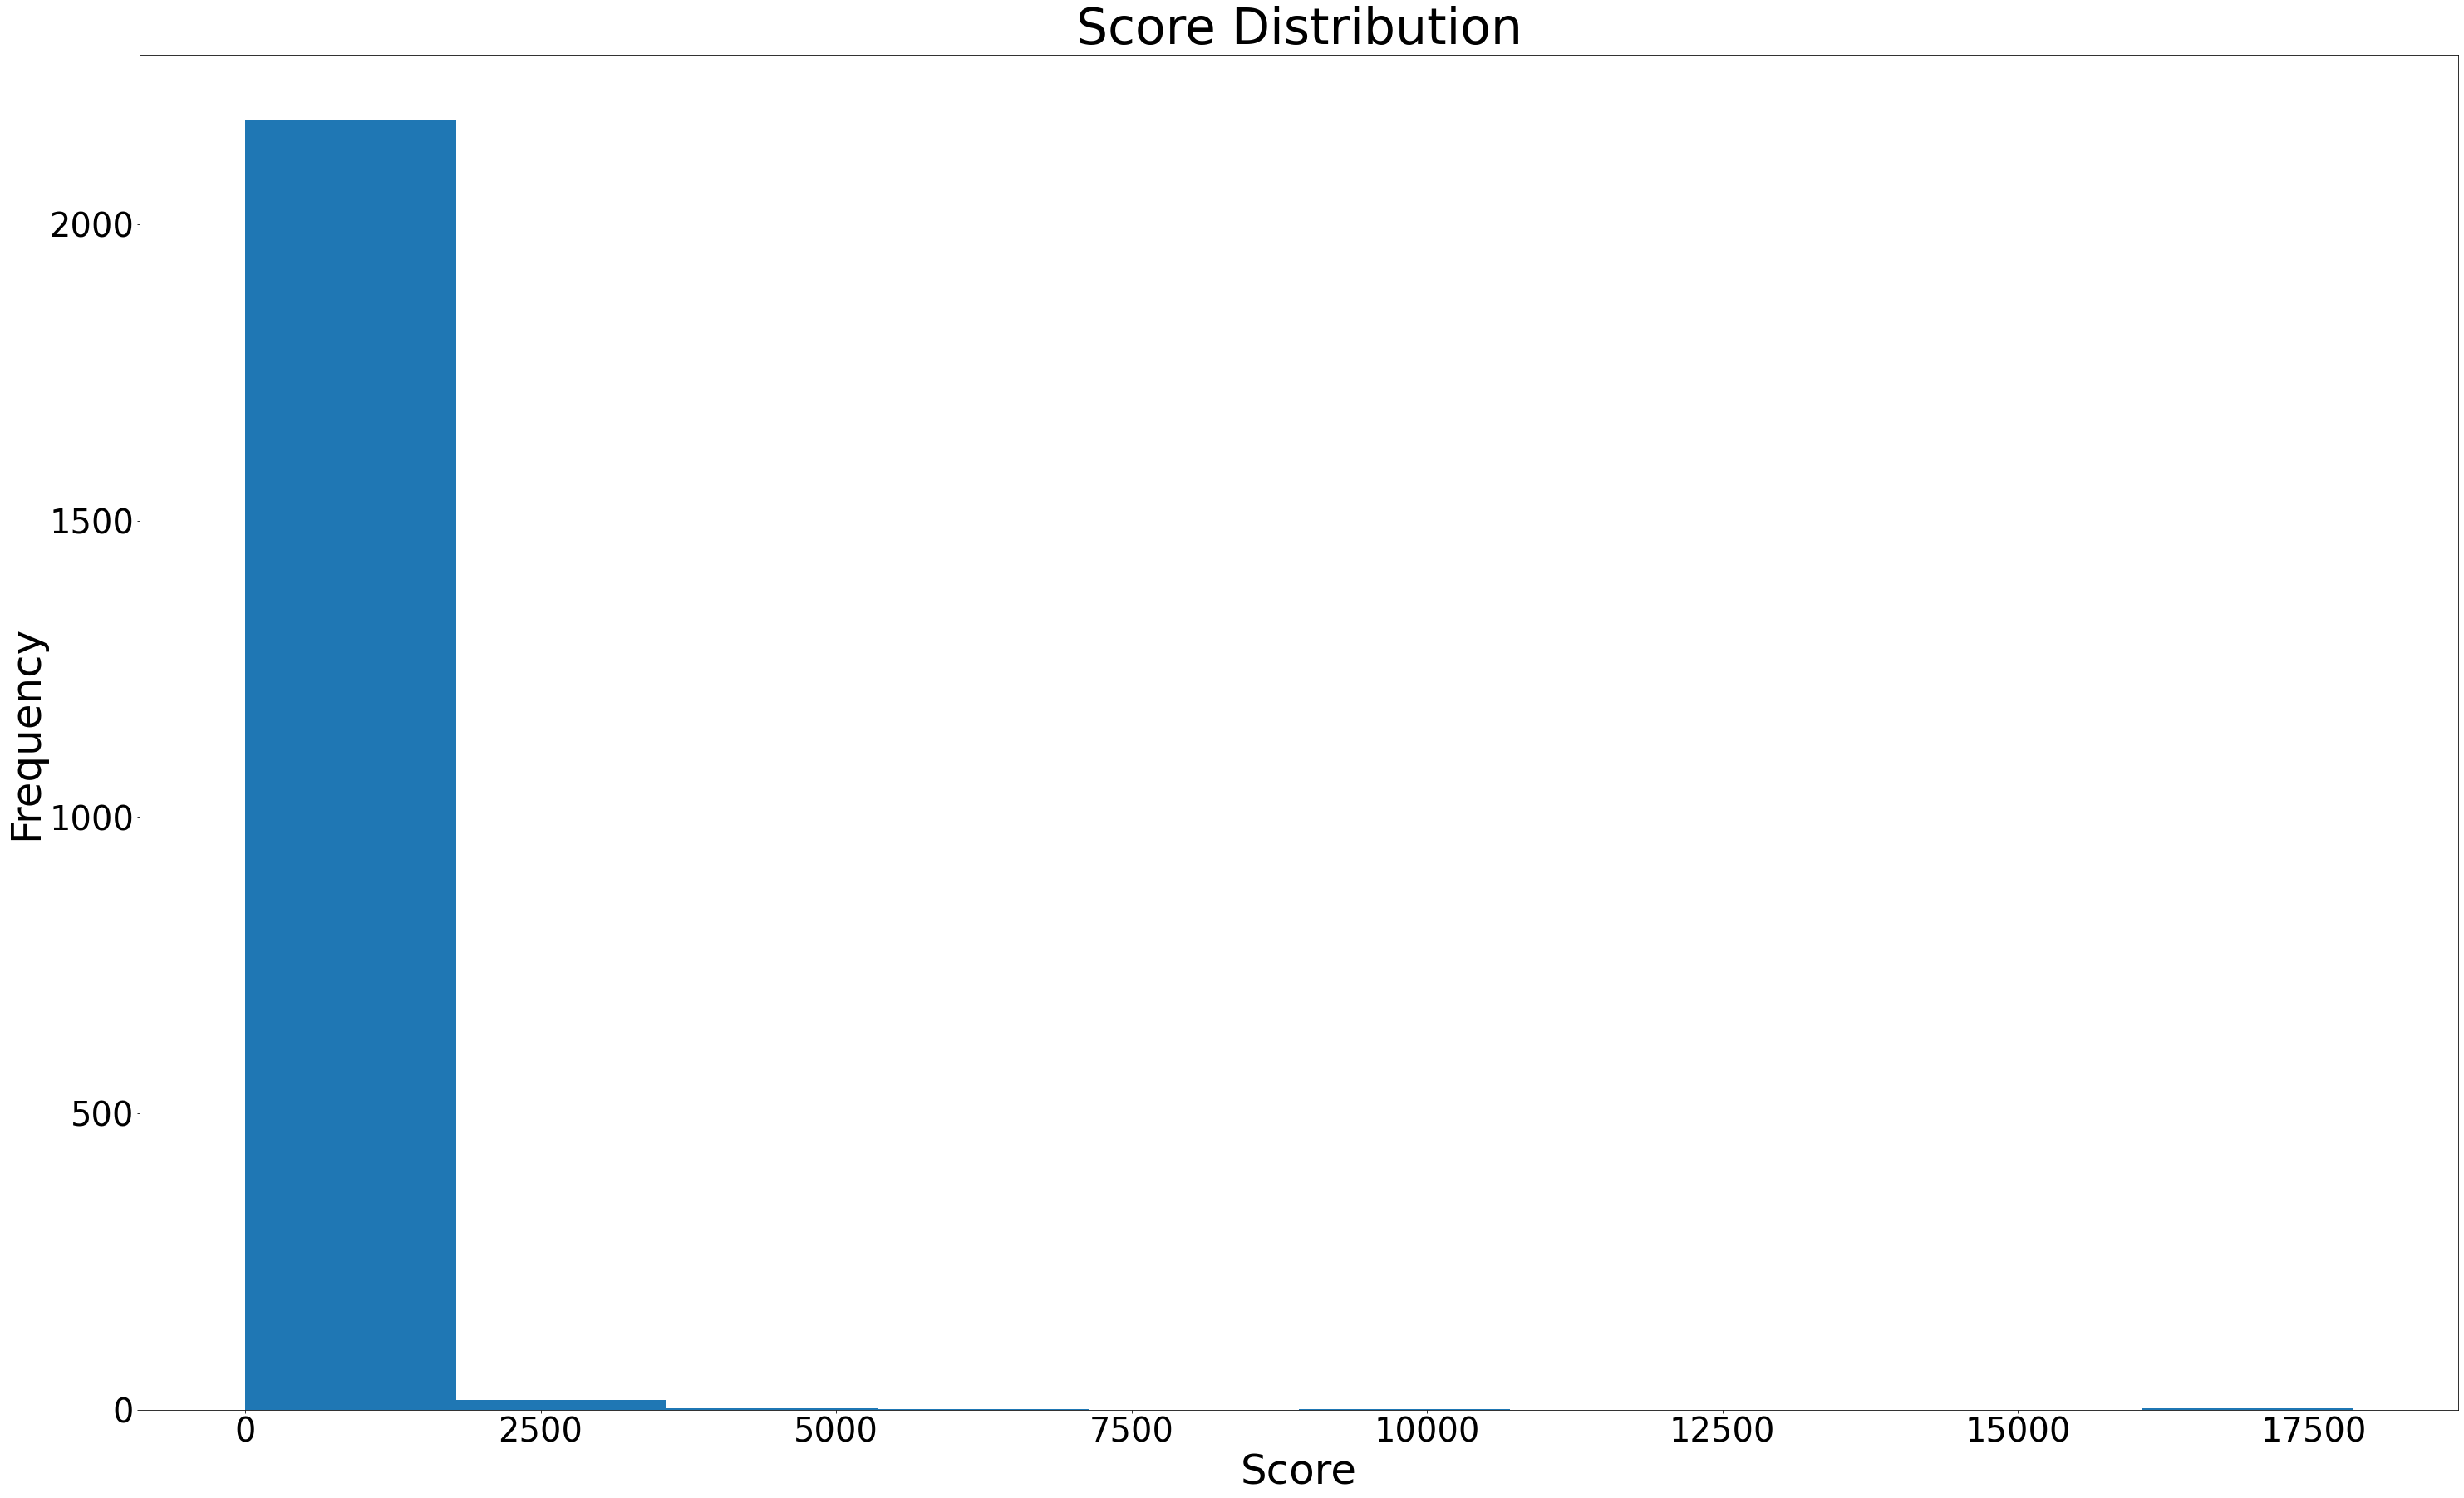

Max score is 17834 and Min score is 0


'Majority of scores are <2500 with traces > 2500 '

In [66]:
plt.figure(figsize=(50,30))
plt.xlabel('Score',fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency',fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['score'],bins=10)
plt.title('Score Distribution',fontsize=60)
plt.show()

print('Max score is {max_score} and Min score is {min_score}'.format(max_score=df.score.max(),min_score = df.score.min()))
'''Majority of scores are <2500 with traces > 2500 '''

Plotting the Histogram of the No of Comments

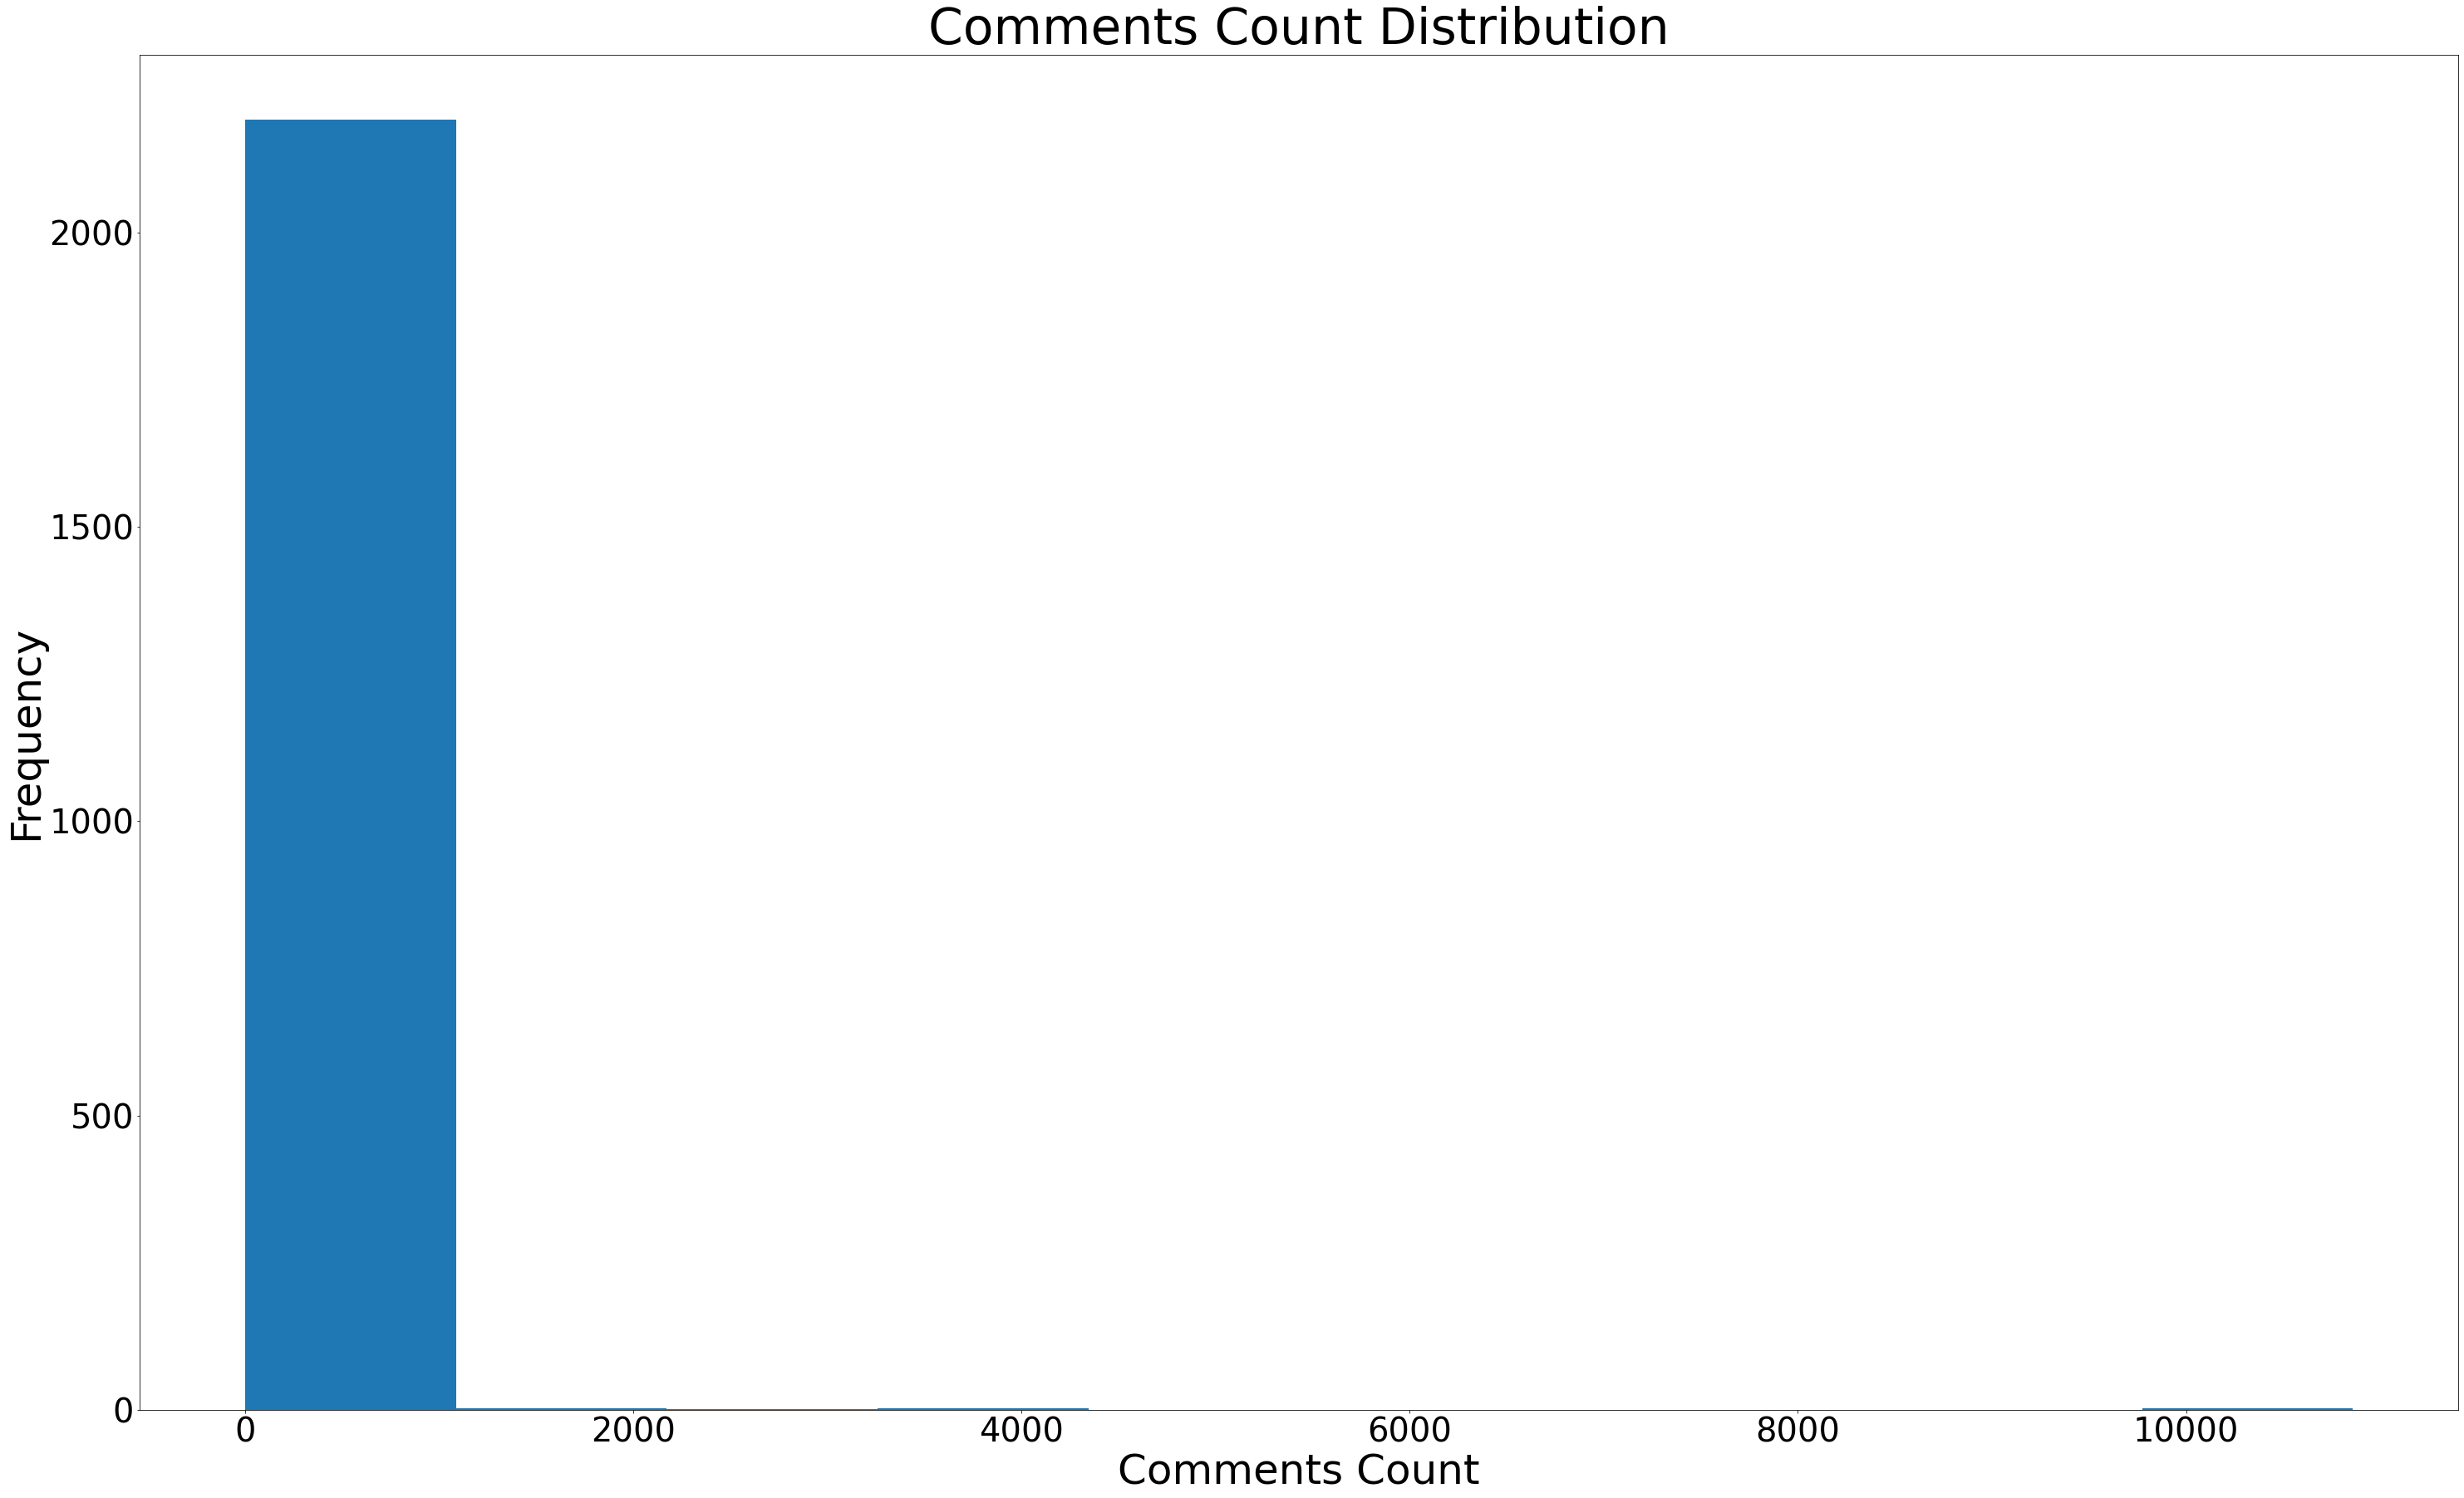

'Vast majority of the reddit posts have <1000 comments'

In [65]:
plt.figure(figsize=(50,30))
plt.xlabel('Comments Count',fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency',fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['num_cmnts'],bins=10,align='mid')
plt.title('Comments Count Distribution',fontsize=60)
plt.show()

'''Vast majority of the reddit posts have <1000 comments'''

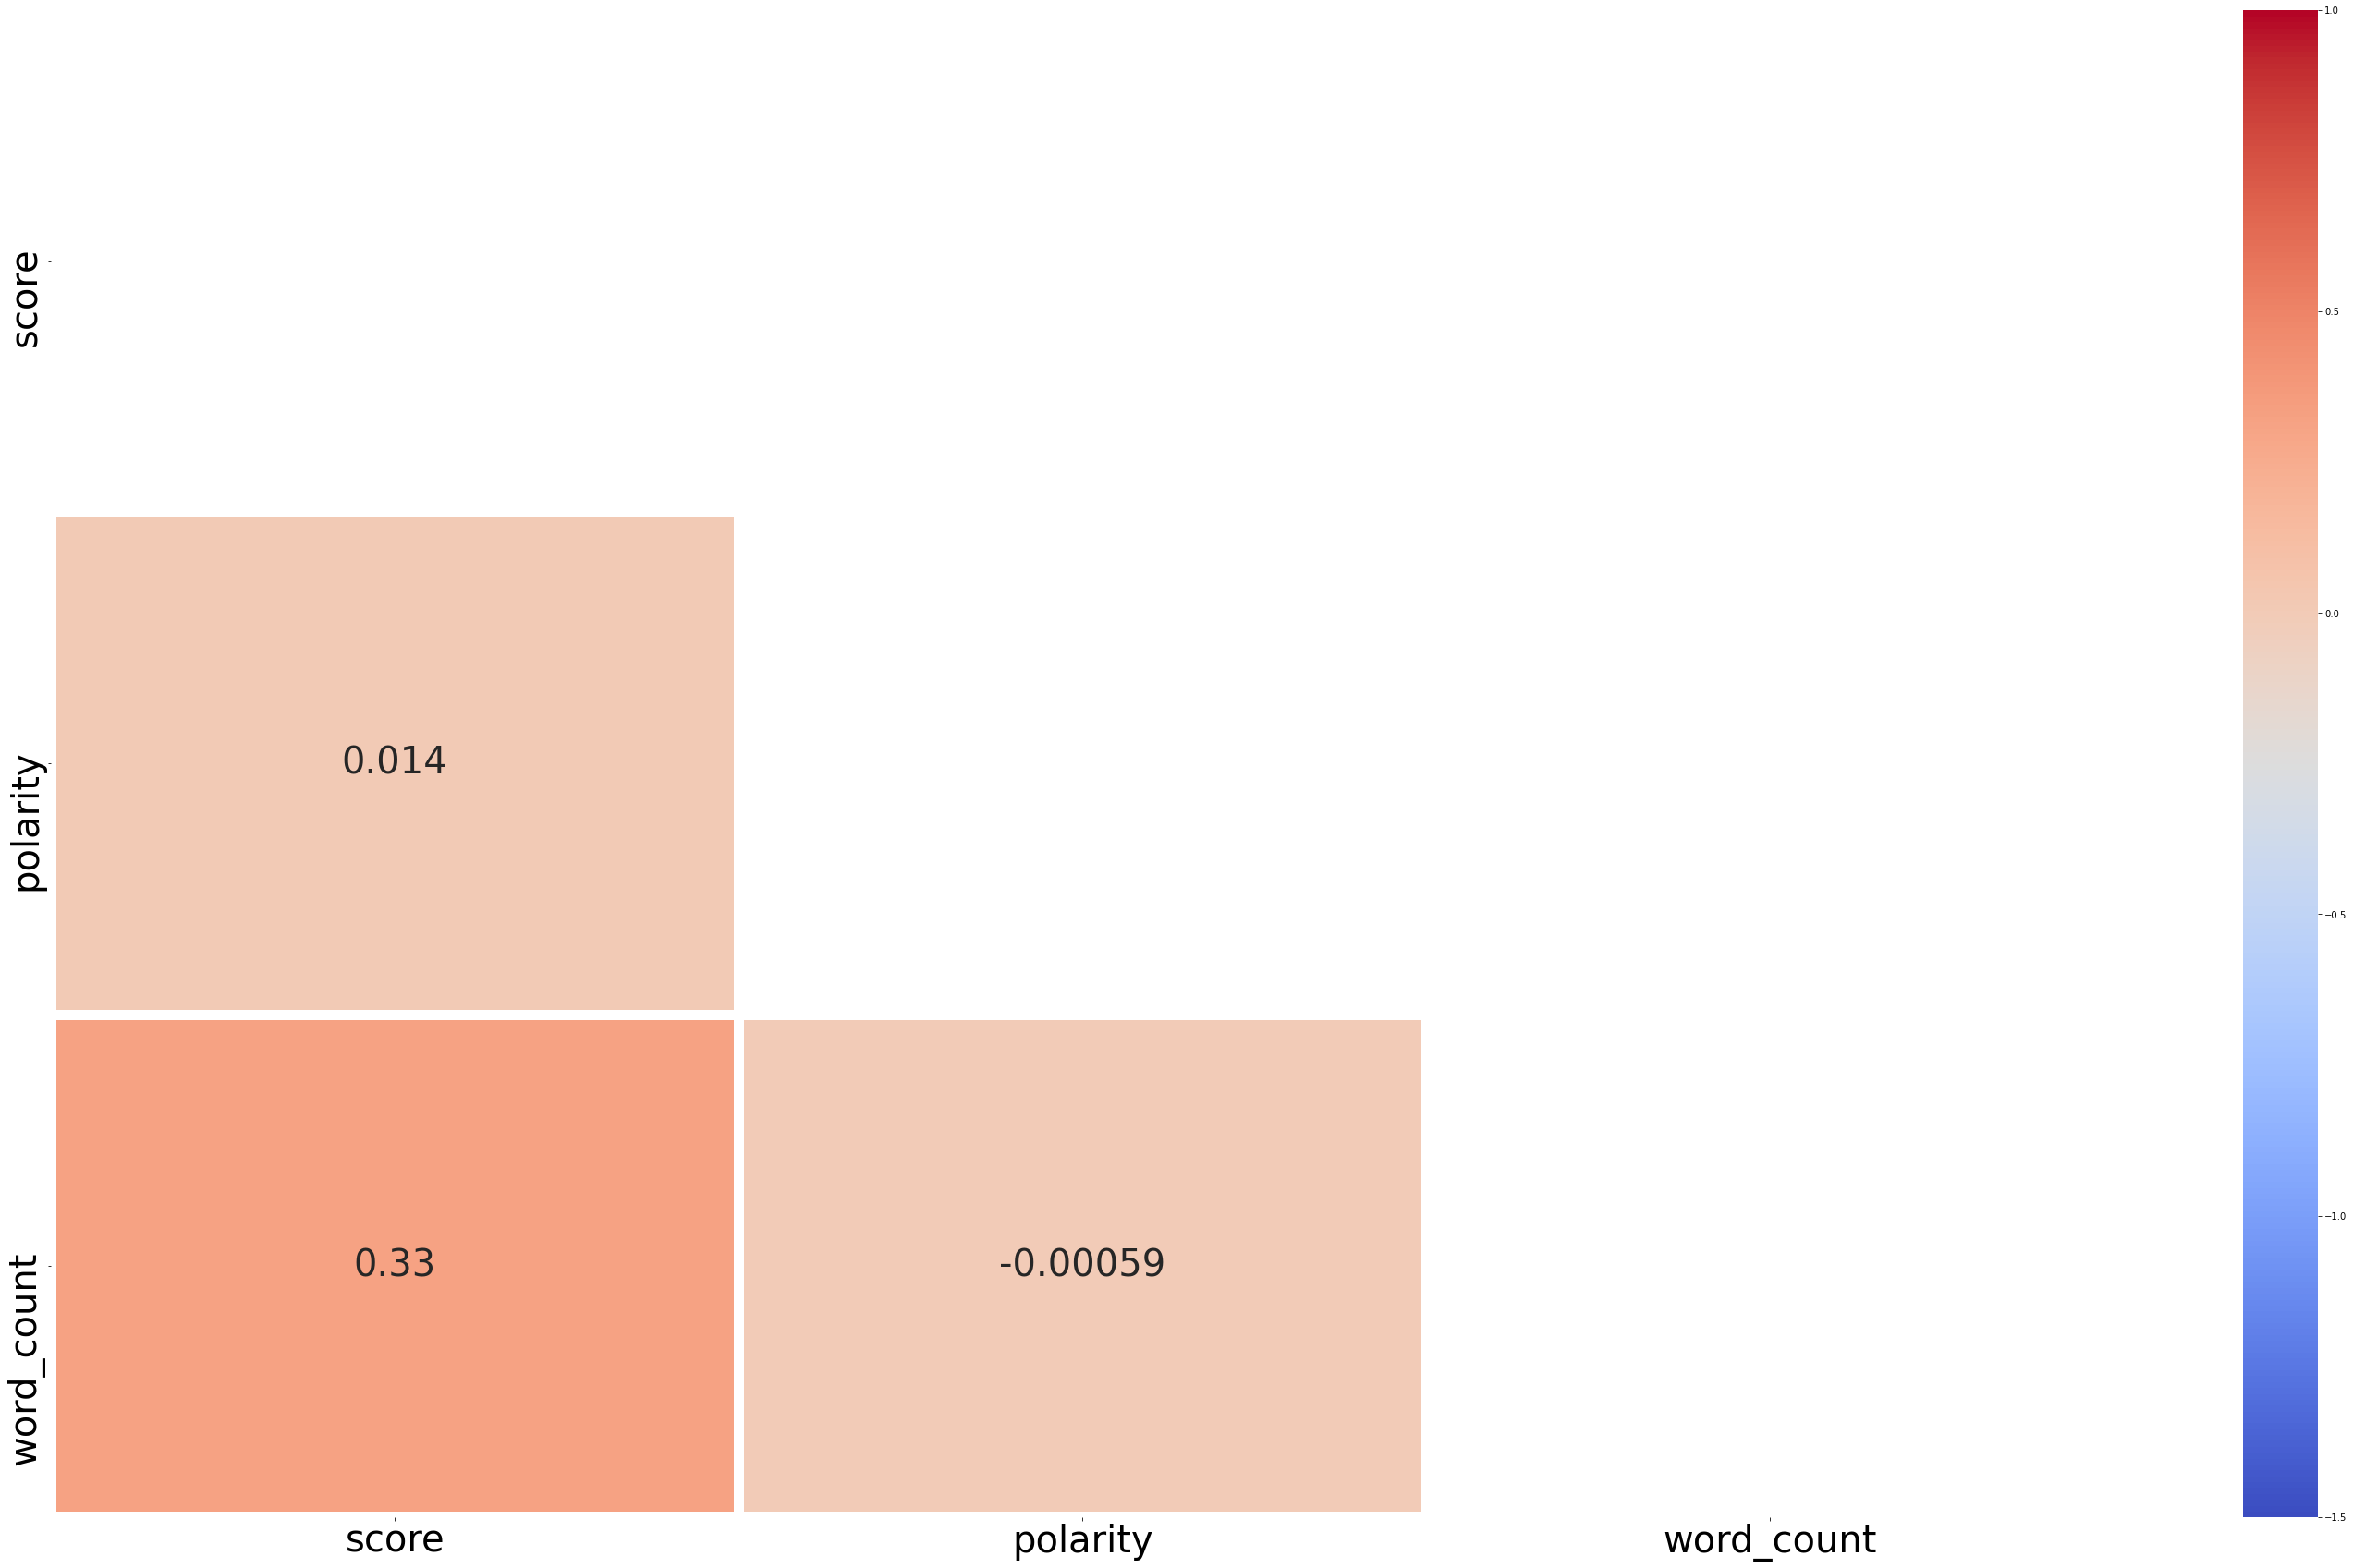

In [108]:
correlation = df[['score','polarity','word_count','flair
                  ']].corr()
mask = np.zeros_like(correlation,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation,cmap='coolwarm',annot=True,annot_kws={'size':40},linewidths=10,vmin=-1.5,mask=mask)

Analysing the word clouds and the most common words in the reddit posts+comments

In [71]:
stopwords = set(STOPWORDS)
def makeWordCloud(textList,stopwords):
    '''
    This function is used to make a wordcloud. 
    It takes two argument one is the list of the texts whose word cloud is to be seen and second is the list of stopwords
    We will use it to see all the words in different flairs
    '''
    words  =' '
    for val in textList: 
        #split each word in the sentences
        tokens = val.split() 
      
        # Convert each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        
        #appending words in string
        for word in tokens: 
            words = words + word + ' '
  
  
    wordcloud = WordCloud(width = 800, height = 800, 
                stopwords = stopwords, 
                min_font_size = 10).generate(words) 
  
    return wordcloud


In [68]:
flairs = [
    'AskIndia','Non-Political','Scheduled','Photography','Coronavirus',
    'Science/Technology','Politics','Business/Finance','Policy/Economy','Sports','Food'
]

wordCloudDict = {}

for flair in flairs:
    wordCloudDict[flair] = None
    
text_dict = wordCloudDict

for flair in flairs:
    rdf = df[df['flair']==flair]
    text_dict[flair] = list(rdf['combined_features'])

In [72]:
for flair in flairs:
    wordCloudDict[flair] = makeWordCloud(text_dict[flair],stopwords)

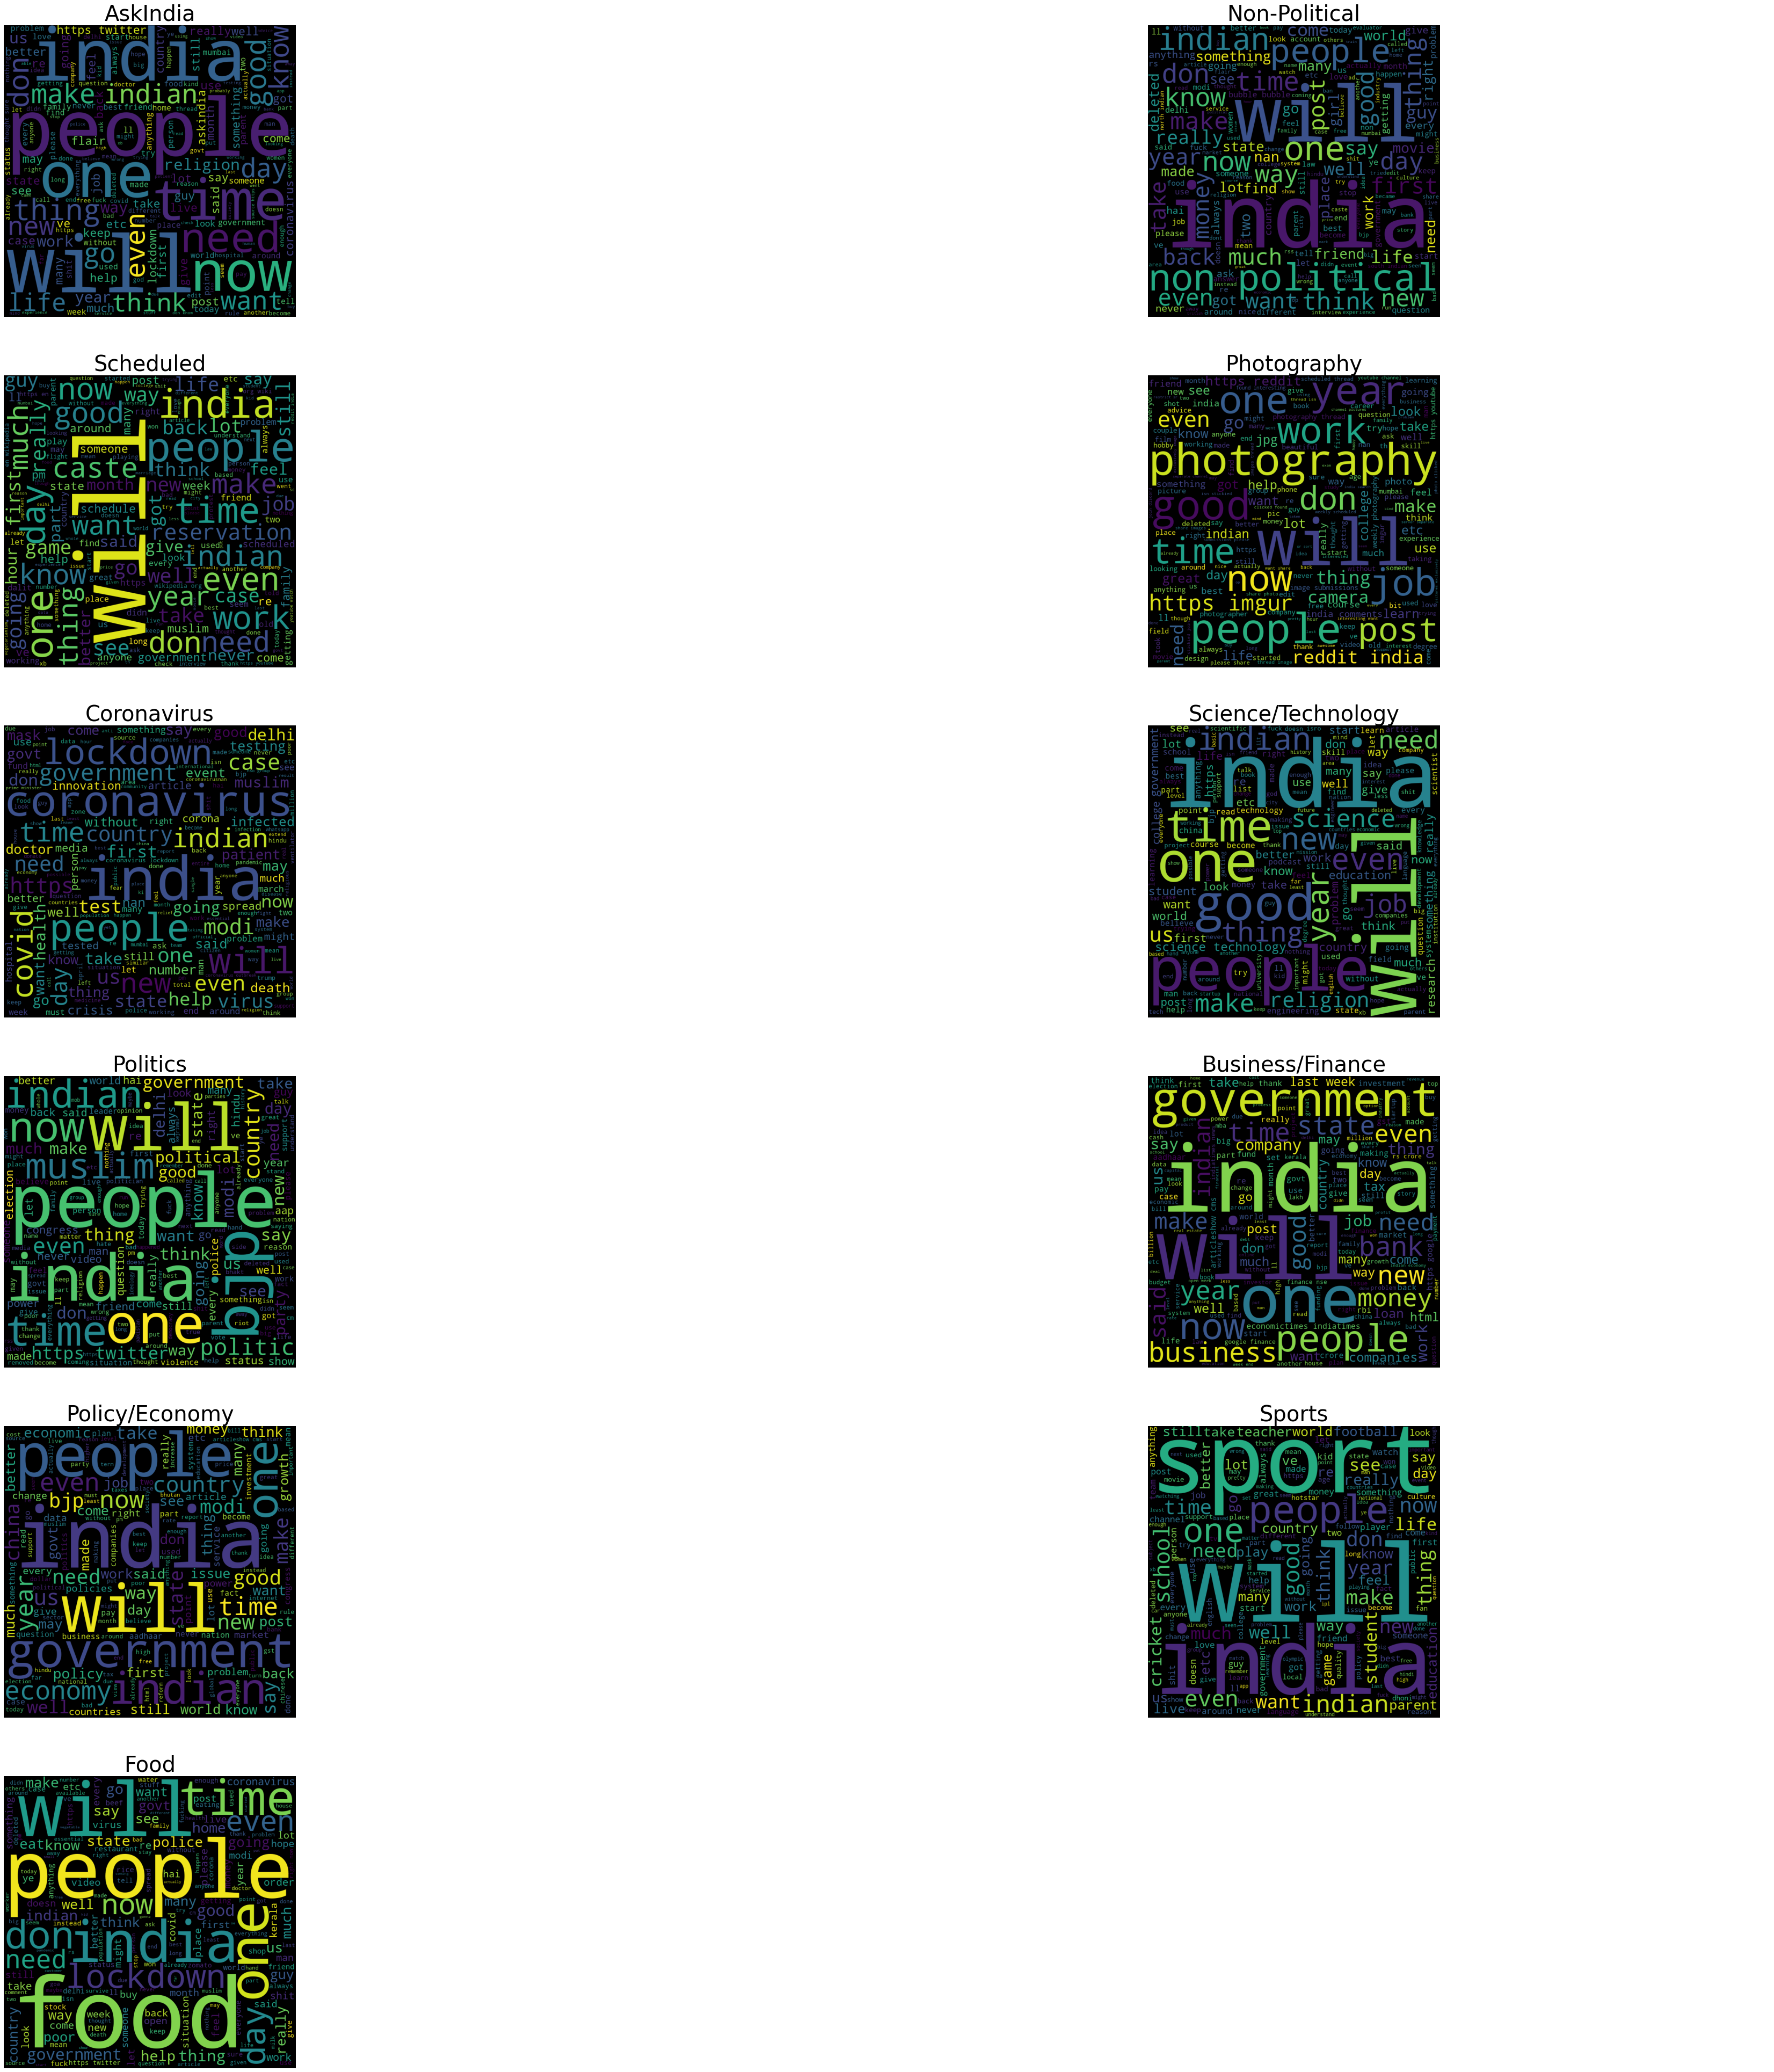

In [106]:
fig,axes = plt.subplots(6,2,figsize=(70,70))
plt.axis('off')
for i in range(11):
        if i%2==0:
            axes[int(i/2),0].imshow(wordCloudDict[flairs[i]])
            axes[int(i/2),0].set_title(flairs[i],fontsize=40)
            axes[int(i/2),0].set_axis_off()
        elif i%2==1:
            axes[int(i/2),1].imshow(wordCloudDict[flairs[i]])
            axes[int(i/2),1].set_title(flairs[i],fontsize=40)
            axes[int(i/2),1].set_axis_off()
fig.savefig("Results.png",dpi=400)